In [126]:
library(tidyverse)
library(tidygraph)
library(igraph)
library(ggpubr)

results <- '../results/'


vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    mutate(degree = centrality_degree()) %>%
    left_join(vegas, by = c('name' = 'Gene'))
ppi_df <- as_tibble(ppi)

gwas <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdccccddd')

load(paste0(results,'scones/gi_network.RData'))
gi <- net %>%
    as_tbl_graph %>%
    mutate(degree = centrality_degree()) %>%
    left_join(gwas, by = c('name' = 'SNP')) %>%
    rename(p = P)
gi_df <- as_tibble(gi)

method_palette <- c('dmGWAS' = '#4daf4a', 'heinz' = '#984ea3',
                    'HotNet2' = '#ff7f00', 'SConES GI' = '#cb181d',
                    'SigMod' = '#377eb8', 'all_snps' = 'black', 'lean' = 'black', 
                    'consensus' = 'black', 'chi2' = '#000080', 'vegas' = 'red')


In [2]:
true_run <- bind_rows(bind_rows(read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c') %>%
                                    mutate(method = 'heinz', run = 'Original', i = NA) %>%
                                    inner_join(ppi_df, by = c('gene' = 'name')) %>%
                                    select(method, run, i, gene, degree, p),
                                read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c') %>%
                                    mutate(method = 'dmGWAS', run = 'Original', i = NA) %>%
                                    inner_join(ppi_df, by = c('gene' = 'name')) %>%
                                    select(method, run, i, gene, degree, p),
                                read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
                                    filter(PLEAN < 0.05) %>%
                                    rename(gene = Gene) %>%
                                    mutate(method = 'LEAN', run = 'Original', i = NA) %>%
                                    inner_join(ppi_df, by = c('gene' = 'name')) %>%
                                    select(method, run, i, gene, degree, p),
                                read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c') %>%
                                    mutate(method = 'SigMod', run = 'Original', i = NA) %>%
                                    inner_join(ppi_df, by = c('gene' = 'name')) %>%
                                    select(method, run, i, gene, degree, p)) %>%
                          mutate(type = 'Gene') %>%
                          select(method, type, run, i, gene, degree, p),
                      read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'ciidccdli') %>%
                          filter(selected) %>%
                          select(snp, c) %>%
                          inner_join(gi_df, by = c('snp' = 'name')) %>%
                          mutate(method = 'SConES GI', run = 'Original', i = NA, type = 'SNP',
                                 gene = snp) %>%
                          select(method, type, run, i, gene, degree, p))

In [66]:
read_heinz <- function() {
    lapply(list.files(paste0(results,'rewiring/heinz'), full.names = T, pattern = 'heinz_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(i = gsub('.*heinz_', '', f)  %>% gsub('.txt', '', .),
                   method = 'heinz')
        }) %>%
        bind_rows
}

read_dmgwas <- function() {
    
    lapply(list.files(paste0(results,'rewiring/dmgwas'), full.names = T, pattern = 'dmgwas_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(i = gsub('.*dmgwas_', '', f)  %>% gsub('.txt', '', .),
                   method = 'dmGWAS')
        }) %>%
        bind_rows
    
}

read_lean <- function() {
    
    lapply(list.files(paste0(results,'rewiring/lean'), full.names = T, pattern = 'lean_*'), function(f) {
        read_tsv(f, col_types = 'cddiidddd') %>%
            filter(PLEAN < 0.05) %>%
            rename(gene = Gene) %>%
            select(gene) %>%
            mutate(i = gsub('.*lean_', '', f)  %>% gsub('.txt', '', .),
                   method = 'LEAN')
    }) %>%
        bind_rows

}

read_sigmod <- function() {
    
    lapply(list.files(paste0(results,'rewiring/sigmod'), full.names = T, pattern = 'sigmod_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(i = gsub('.*sigmod_', '', f)  %>% gsub('.txt', '', .),
                   method = 'SigMod')
        }) %>%
        bind_rows
    
}

read_scones <- function() {
    lapply(list.files(paste0(results,'rewiring/scones'), full.names = T, pattern = 'cones_*'), function(f) {
        read_tsv(f, col_types = 'ciidccdli') %>%
            filter(selected) %>%
            select(snp, c) %>%
            mutate(i = gsub('.*cones_', '', f)  %>% gsub('.tsv', '', .),
                   method = 'SConES GI', type = 'SNP')
        }) %>%
        bind_rows %>%
        inner_join(gi_df, by = c('snp' = 'name')) %>%
        mutate(gene = snp,
               run = 'Rewired') %>%
        select(method, type, run, i, gene, degree, p)
}

runs <- bind_rows(read_dmgwas(),
                  read_heinz(),
                  read_lean(),
                  read_sigmod()) %>%
    mutate(run = 'Rewired', type = 'Gene') %>%
    inner_join(ppi_df, by = c('gene' = 'name'))  %>%
    select(method, type, run, i, gene, degree, p) %>%
    bind_rows(true_run,
              read_scones())

compare_property <- function(runs, property, label) {

    runs_cpy <- runs
    runs_cpy[['x']] <- runs_cpy[[property]]
    
    runs_sum <- runs_cpy %>%
        group_by(method, type, run, i) %>%
        summarize(x = median(x))
    
    p_vals <- runs_sum %>%
        group_by(method, type) %>%
        summarize(p = ecdf(x[run == 'Rewired'])(x[run == 'Original']) %>%
                      format(digits = 2),
                  val = x[run == 'Original'])

    ggplot() +
            geom_boxplot(data = filter(runs_sum, run == 'Rewired'),
                         aes(x = method, y = x)) +
            geom_point(data = filter(runs_sum, run == 'Original'), 
                       aes(x = method, y = x), 
                       color = 'red', size = 5) +
            geom_text(data = p_vals,
                      aes(x = method, y = val, label = p), jitter = 0.5) +
            labs(y = label) +
            facet_wrap(. ~ type, scales = 'free') +
            theme(legend.position = 'bottom')
    
}

`summarise()` regrouping output by 'method', 'type', 'run' (override with `.groups` argument)

`summarise()` regrouping output by 'method', 'type', 'run' (override with `.groups` argument)

`summarise()` regrouping output by 'method' (override with `.groups` argument)

Warning message:
“Ignoring unknown parameters: jitter”


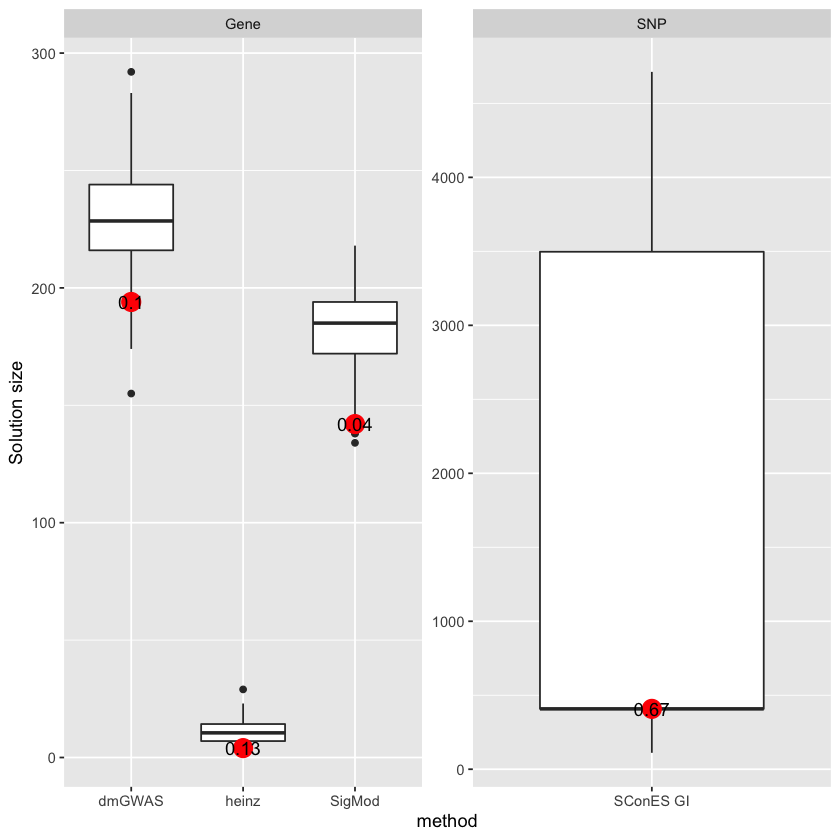

In [67]:
runs %>%
    group_by(method, type, run, i) %>%
    summarize(n = n()) %>%
    compare_property('n', 'Solution size')

`summarise()` regrouping output by 'method', 'type', 'run' (override with `.groups` argument)

`summarise()` regrouping output by 'method', 'type', 'run' (override with `.groups` argument)

`summarise()` regrouping output by 'method' (override with `.groups` argument)

Warning message:
“Ignoring unknown parameters: jitter”


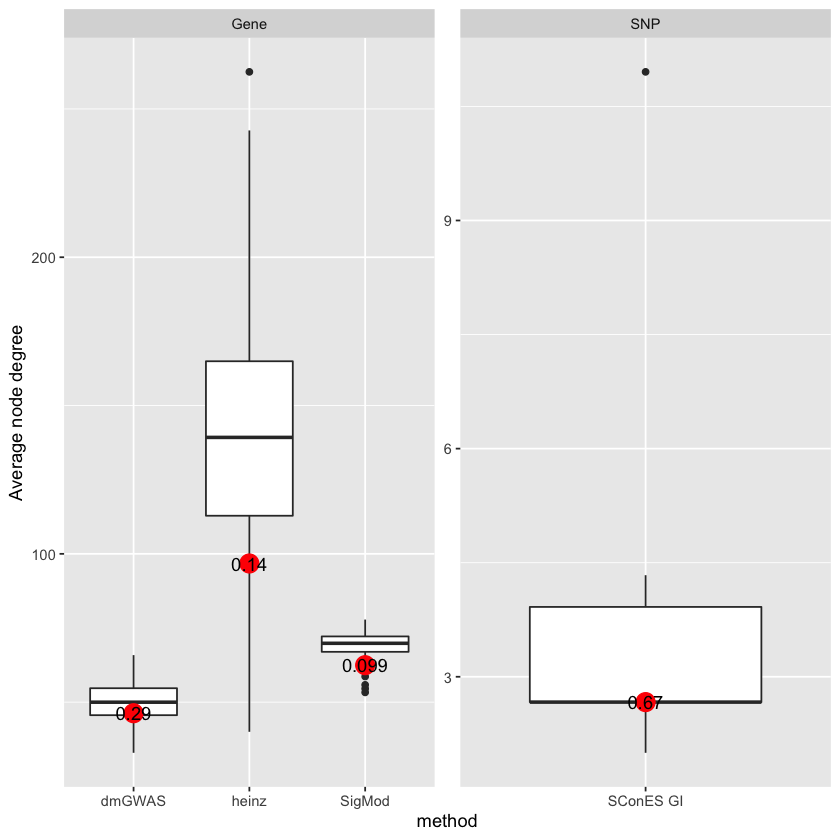

In [68]:
runs %>%
    group_by(method, type, run, i) %>%
    summarize(degree = mean(degree)) %>%
    compare_property('degree', 'Average node degree')

`summarise()` regrouping output by 'method', 'type', 'run' (override with `.groups` argument)

`summarise()` regrouping output by 'method' (override with `.groups` argument)

Warning message:
“Ignoring unknown parameters: jitter”


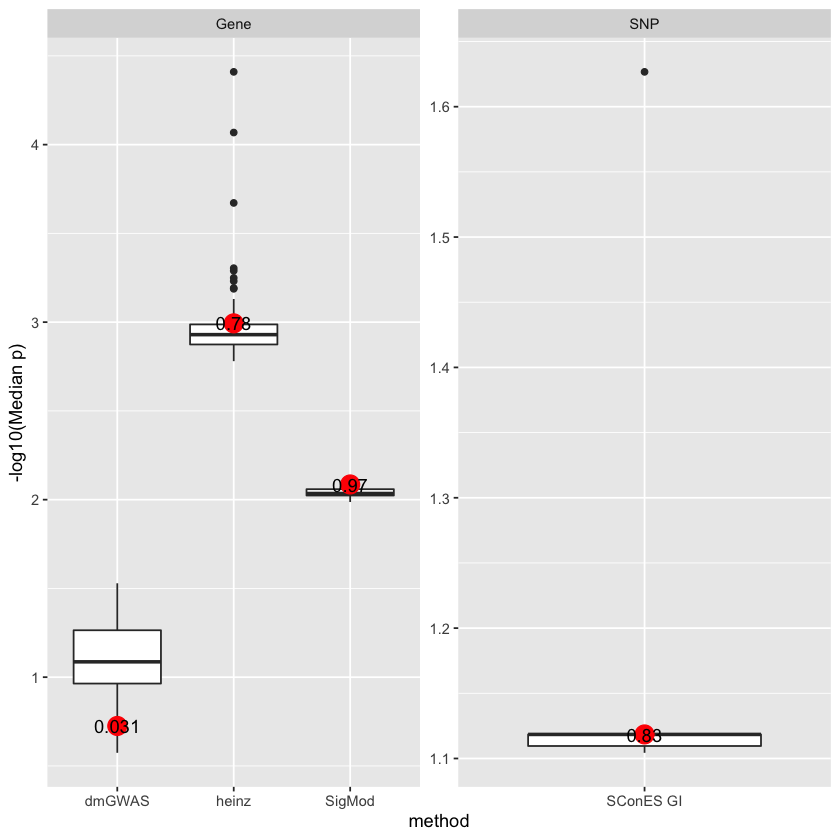

In [69]:
mutate(runs, logp = -log10(p)) %>%
    compare_property('logp', '-log10(Median p)')

- Check the distributions?

`summarise()` regrouping output by 'gene' (override with `.groups` argument)

`geom_smooth()` using formula 'y ~ x'



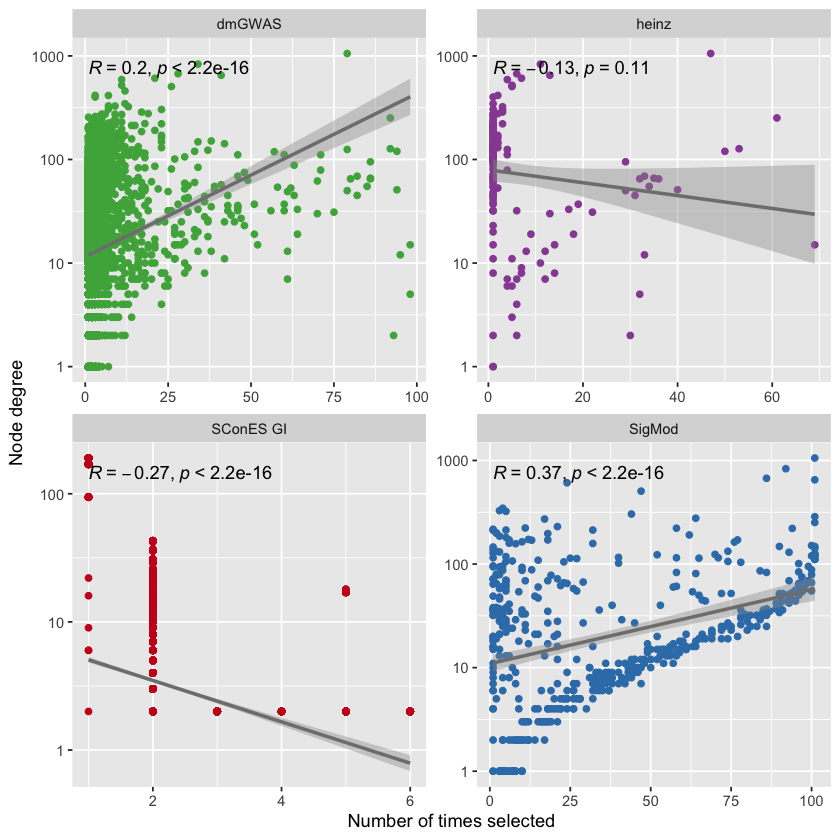

In [129]:
gene_agg <- runs %>%
    filter(run == 'Rewired') %>%
    group_by(gene, method) %>%
    summarize(n = n(), degree = median(degree), p = median(p))

ggplot(gene_agg, aes(x = n, y = degree)) +
    geom_point(aes(color = method)) +
    geom_smooth(method = "glm", color = 'gray50') +
    stat_cor(color = 'black') +
    scale_y_log10() +
    labs(x = 'Number of times selected', y = 'Node degree') +
    facet_wrap(method ~ ., scales = 'free') +
    scale_color_manual(values = method_palette) +
    theme(legend.position = 'none')

`summarise()` regrouping output by 'gene' (override with `.groups` argument)

`geom_smooth()` using formula 'y ~ x'



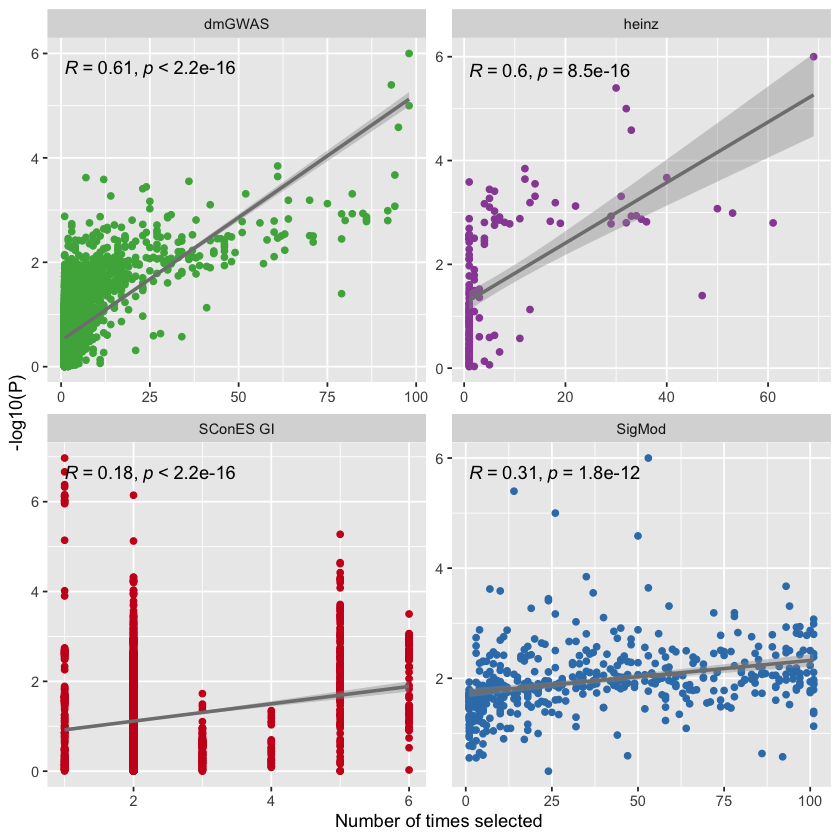

In [125]:
ggplot(gene_agg, aes(x = n, y = -log10(p))) +
    geom_point(aes(color = method)) +
    geom_smooth(method = "glm", color = 'gray50') +
    stat_cor(color = 'black') +
    labs(x = 'Number of times selected', y = '-log10(P)') +
    facet_wrap(method ~ ., scales = 'free') +
    scale_color_manual(values = method_palette) +
    theme(legend.position = 'none')

`summarise()` ungrouping output (override with `.groups` argument)



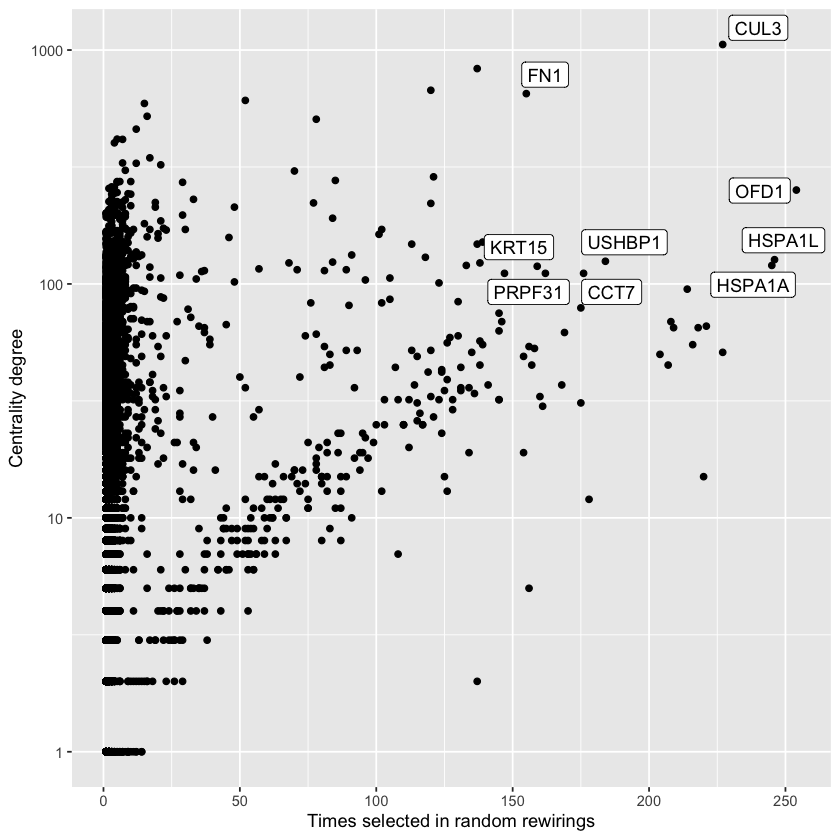

In [144]:
library(ggrepel)

gene_agg <- runs %>%
    filter(run == 'Rewired' & method != 'SConES GI') %>%
    group_by(gene) %>%
    summarize(n = n(), degree = median(degree))

ggplot() +
    geom_point(data = gene_agg, aes(x = n, y = degree)) +
    geom_label_repel(data = filter(gene_agg, n > 150 & degree > 100), 
                     aes(x = n, y = degree, label = gene)) +
    scale_y_log10() +
    labs(x = 'Times selected in random rewirings', y = 'Centrality degree')

- Check how many edges are kept between permutations